In [1]:
import os

import numpy as np
import pickle

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist

from utils import STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH, SUBJECTS, FMRI_DATA_DIR
from eval import get_distance_matrix
from data import get_fmri_data_paths, get_latent_features, LatentFeatsConfig, standardize_latents, IMAGE, CAPTION
from analyses.decoding.ridge_regression_decoding import get_run_str, RIDGE_DECODER_OUT_DIR, RESULTS_FILE
from feature_extraction.feat_extraction_utils import CoCoDataset
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange
from preprocessing.create_gray_matter_masks import get_graymatter_mask_path
import nibabel
from PIL import Image
import pandas as pd
from IPython.display import display, HTML
from io import BytesIO
import base64


/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH)

In [3]:
def resize_img(image, length=100):
    if image.size[0] < image.size[1]:
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))
        required_loss = (resized_image.size[1] - length)
        resized_image = resized_image.crop(box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))
    else:
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))
        required_loss = resized_image.size[0] - length
        resized_image = resized_image.crop(box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))
    return resized_image

def display_stimuli(coco_ids, imgs=True, caps=True):
    if caps:
        for coco_id in coco_ids:
            print(coco_ds.captions[coco_id], end="\n")

    if imgs:
        imgs = [np.array(resize_img(coco_ds.get_img_by_coco_id(img_id))) for img_id in coco_ids]        
        img = Image.fromarray(np.hstack(imgs))
        display(img)

def get_distance_matrix(predictions, originals, metric='cosine'):
    dist = cdist(predictions, originals, metric=metric)
    return dist
    
def dist_mat_to_pairwise_acc(dist_mat, stim_ids, print_details=False):
    diag = dist_mat.diagonal().reshape(-1, 1)
    comp_mat = diag < dist_mat
    corrects = comp_mat.sum()
    if print_details:
        for i, stim_id in enumerate(stim_ids):
            print(stim_id, end=': ')
            print(f'{comp_mat[i].sum() / (len(comp_mat[i]) - 1):.2f}')
    # subtract the number of elements of the diagonal as these values are always "False" (not smaller than themselves)
    score = corrects / (dist_mat.size - diag.size)
    return score

def dist_mat_to_rankings(dist_mat, stim_ids, candidate_set_latent_ids):
    all_ranks = []
    for test_stimulus_id, nneighbors_row in zip(stim_ids, dist_mat):
        nneighbors_ids = candidate_set_latent_ids[np.argsort(nneighbors_row)]
        rank = np.argwhere(nneighbors_ids == test_stimulus_id)[0][0]

        all_ranks.append(rank)
            
    return np.mean(all_ranks)

def plot_nn_table(stim_ids, nneighbors, stim_type):
    df = pd.DataFrame({'stimulus': stim_ids} | {f'nn_{i}': [n[i] for n in nneighbors] for i in range(len(nneighbors[0]))})
        
    def image_base64(img_id, length=150):
        im = resize_img(coco_ds.get_img_by_coco_id(img_id), length=length)
        with BytesIO() as buffer:
            im.save(buffer, 'jpeg')
            decoded = base64.b64encode(buffer.getvalue()).decode()
            return decoded
    
    def stimulus_formatter(img_id, width=150, height=200):
        if stim_type == IMAGE:
            formatted = f'<div style="height:{height}px; width:{width}px; vertical-align:top"><img src="data:image/jpeg;base64,{image_base64(img_id)}"></div>'
        else:
            formatted = f'<div style="height:{height}px; width:{width}px; vertical-align:top">{coco_ds.captions[img_id]}</div>'
        return formatted
            
    def image_and_cap_formatter(img_id, width=150, height=200):
        img = image_base64(img_id)
        formatted = f'<div style="height:{height}px; width:{width}px; vertical-align:top; text-align:left"><img src="data:image/jpeg;base64,{img}">'
        cap = coco_ds.captions[img_id]
        formatted += f'<br>{cap}</div>'
        return formatted
            
    pd.set_option('display.max_colwidth', None)
    
    custom_formatters = {'stimulus': stimulus_formatter} | {f'nn_{i}': image_and_cap_formatter for i in range(len(nneighbors[0]))}
    # custom_formatters = {'stimulus': image_and_cap_formatter} | {f'nn_{i}': image_and_cap_formatter for i in range(len(nneighbors[0]))}


    display(HTML(df.to_html(formatters=custom_formatters, escape=False, index=False)))



# Nearest Neighbors of test images

In [4]:
def load(betas_dir, model, subject, mode, feats_config):    
    train_paths, stim_ids, stim_types = get_fmri_data_paths(betas_dir, subject, mode)
    
    train_latents = get_latent_features(model, feats_config, stim_ids, stim_types)
    train_paths = np.array(train_paths)
    
    test_paths, test_stim_ids, test_stim_types = get_fmri_data_paths(betas_dir, subject, "test")
    test_paths = np.array(test_paths)
    test_latents = get_latent_features(model, feats_config, test_stim_ids, test_stim_types)
    
    train_latents, test_latents = standardize_latents(train_latents, test_latents)
    
    gray_matter_mask_data = nibabel.load(get_graymatter_mask_path(subject)).get_fdata()
    gray_matter_mask = gray_matter_mask_data == 1
    print(f"Gray matter mask size: {gray_matter_mask.sum()}")
    
    run_str = get_run_str(betas_dir, model, feats_config)
    results_file_path = os.path.join(
        RIDGE_DECODER_OUT_DIR, mode, subject, run_str, RESULTS_FILE
    )
    print(f'loading decoder results from: \n', results_file_path)
    results = pickle.load(open(results_file_path, 'rb'))
    
    test_stim_types = results['stimulus_types']
    test_stim_ids = results['stimulus_ids']
    pred_latents = results['predictions']
    test_latents = results['latents']
    
    pred_latents_standardized = StandardScaler().fit_transform(pred_latents)
    return stim_ids, stim_types, train_latents, test_latents, test_stim_ids, test_stim_types, gray_matter_mask, train_paths, test_paths, pred_latents, pred_latents_standardized

def load_betas(train_paths, test_paths):
    train_fmri_betas = []
    for idx in trange(len(train_paths), desc="loading fmri data"):
        sample = nibabel.load(train_paths[idx]).get_fdata()
        sample = sample[gray_matter_mask].astype('float32').reshape(-1)
        train_fmri_betas.append(sample)
    
    train_fmri_betas = np.array(train_fmri_betas)

    test_fmri_betas = []
    for idx in trange(len(test_paths), desc="loading fmri data"):
        sample = nibabel.load(test_paths[idx]).get_fdata()
        sample = sample[gray_matter_mask].astype('float32').reshape(-1)
        test_fmri_betas.append(sample)
    
    test_fmri_betas = np.array(test_fmri_betas)

    scaler = StandardScaler()
    scaler.fit(train_fmri_betas)
    train_fmri_betas_standardized = scaler.transform(train_fmri_betas)
    test_fmri_betas_standardized = scaler.transform(test_fmri_betas)
    
    return train_fmri_betas, test_fmri_betas, train_fmri_betas_standardized, test_fmri_betas_standardized



In [16]:
SUBJECT = 'sub-01'
MODEL = "imagebind"

MODE = "train_image"
# MODE = "train"

# BETAS_SUFFIX = 'betas_one_step_skip_oneback_ignore_subjresp'
# BETAS_SUFFIX = 'betas_backup'
BETAS_SUFFIX = 'betas'
# BETAS_SUFFIX = 'betas_one_step_backup'

BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

# feats = 'avg'
# test_feats = 'avg'
FEATS = 'default'
TEST_FEATS = 'default'
# feats = 'lang'
# test_feats = 'lang'
# vision_feats = 'vision_features_cls'
VISION_FEATS = 'default'
# vision_feats = 'n_a'

LANG_FEATS = 'default'
# lang_feats = 'lang_features_cls'
# lang_feats = 'lang_features_mean'

FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)

stim_ids, stim_types, train_latents, test_latents, test_stim_ids, test_stim_types, gray_matter_mask, train_paths, test_paths, pred_latents, pred_latents_standardized = load(BETAS_DIR, MODEL, SUBJECT, MODE, FEATS_CONFIG)

N_TRAIN_BETAS = 1000
train_paths = train_paths[np.random.choice(range(len(train_paths)), size=N_TRAIN_BETAS, replace=False)]


Selected default features for imagebind: avg
Selected default test features for imagebind: avg
Selected default vision features for imagebind: vision_features_cls
Selected default language features for imagebind: lang_features_cls
Gray matter mask size: 162649
loading decoder results from: 
 /home/mitja/data/multimodal_decoding/whole_brain_decoding/train_image/sub-01/imagebind_avg_test_avg_vision_features_cls_lang_features_cls_betas/results.p


In [7]:
train_fmri_betas, test_fmri_betas, train_fmri_betas_standardized, test_fmri_betas_standardized = load_betas(train_paths, test_paths)

loading fmri data: 100%|██████████| 140/140 [00:06<00:00, 22.01it/s]


In [ ]:
# def plot_betas(train_betas, test_betas, title, binwidth=3):
#     X = np.concatenate((train_betas.flatten(), test_betas.flatten()))
#     hue = ['train'] * train_betas.size + ['test'] * test_betas.size
#     plt.figure(figsize=(20, 10))
#     sns.histplot(x=X, hue=hue, binwidth=binwidth)
#     plt.title(title)

# print(np.nanmean(train_fmri_betas.mean(axis=0)))
# print(np.nanmean(test_fmri_betas.mean(axis=0)))
# print(np.nanmean(train_fmri_betas_standardized.mean(axis=0)))
# print(np.nanmean(test_fmri_betas_standardized.mean(axis=0)))

# plot_betas(train_fmri_betas, test_fmri_betas, title='unstandardized')
# plt.ylim(0, 10000000)
# plt.xlim(-25, 25)

# plot_betas(train_fmri_betas_standardized, test_fmri_betas, title='standardized', binwidth=0.3)
# plt.ylim(0, 4000000)
# plt.xlim(-3, 3)

# TSNE for Betas

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1140 samples in 0.089s...
[t-SNE] Computed neighbors for 1140 samples in 17.982s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1140
[t-SNE] Computed conditional probabilities for sample 1140 / 1140
[t-SNE] Mean sigma: 207.363482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.191216
[t-SNE] KL divergence after 1000 iterations: 2.228760
(1140, 2)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1140 samples in 0.088s...
[t-SNE] Computed neighbors for 1140 samples in 16.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1140
[t-SNE] Computed conditional probabilities for sample 1140 / 1140
[t-SNE] Mean sigma: 54.218345
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.944733
[t-SNE] KL divergence after 1000 iterations: 2.253458
(1140, 2)


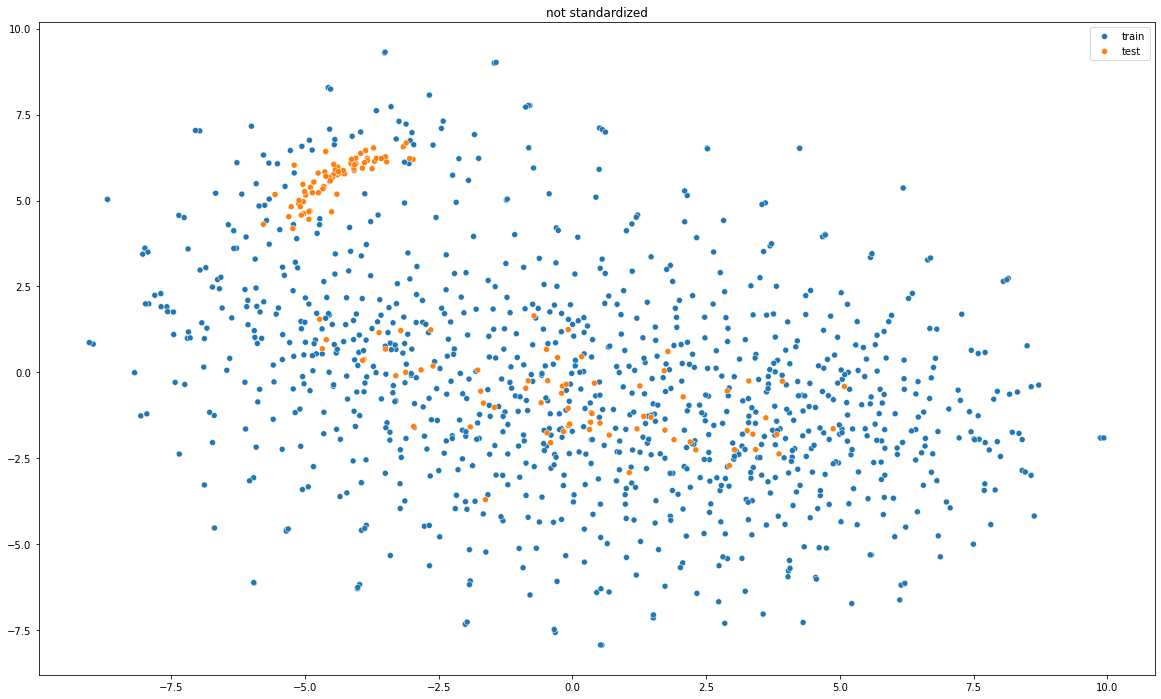

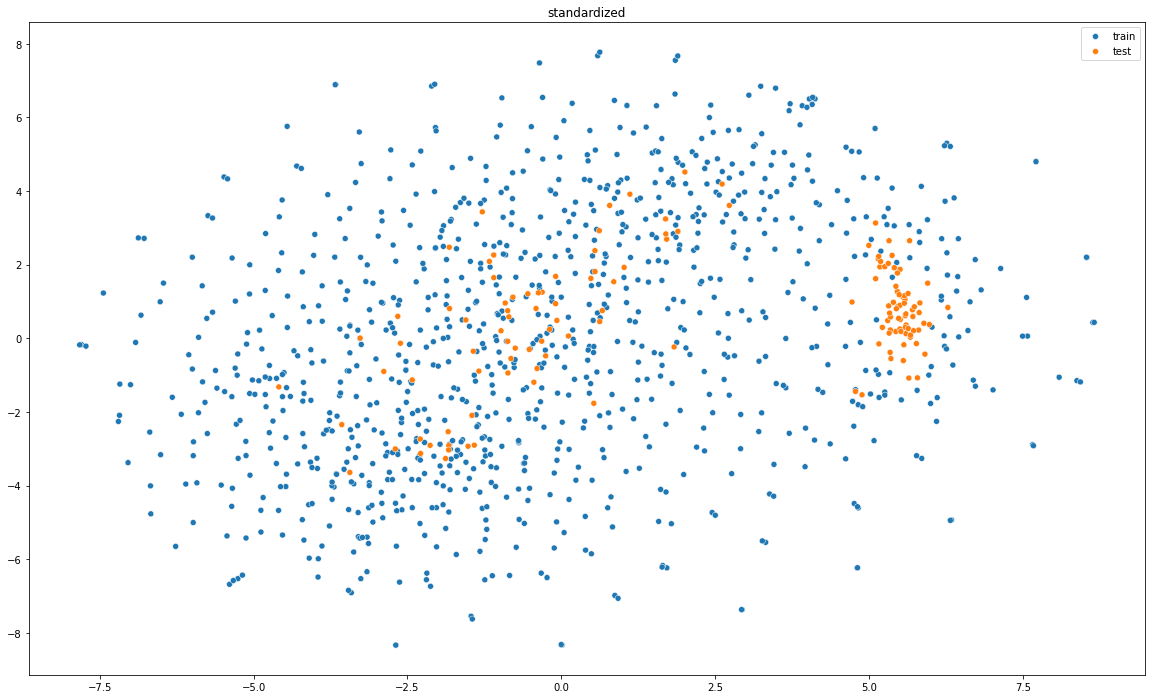

In [8]:
def plot_betas_tfce(train_betas, test_betas, title, train_subset=None):
    if train_subset is not None:
        train_betas_subset = train_betas[np.random.choice(range(len(train_betas)), size=train_subset, replace=False)]
    else:
        train_betas_subset = train_betas
    train_test = np.concatenate((train_betas_subset, test_betas))
    tsne = TSNE(n_components=2, learning_rate='auto', verbose=1, n_jobs=10, n_iter=1000)
    X_embedded = tsne.fit_transform(train_test)
    
    print(X_embedded.shape)
    assert X_embedded.shape[1] == 2
    hue = ['train'] * len(train_betas_subset) + ['test'] * len(test_betas)
    # alpha = [1] * len(test_betas) + [0.3] * len(train_betas_subset)
    
    plt.figure(figsize=(20, 12))
    sns.scatterplot(
        x = X_embedded[:, 0], y = X_embedded[:, 1],
        hue = hue,
        # alpha = alpha
    )
    plt.title(title)

plot_betas_tfce(train_fmri_betas, test_fmri_betas, title="not standardized")
plot_betas_tfce(train_fmri_betas_standardized, test_fmri_betas_standardized, "standardized")


# TSNE for Latents

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.001s...
[t-SNE] Computed neighbors for 1280 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 1.954709
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.477867
[t-SNE] KL divergence after 1000 iterations: 1.356019
(1280, 2)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.001s...
[t-SNE] Computed neighbors for 1280 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 11.683204
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.617180
[t-SNE] KL divergence after 1000 iterations: 1.284709
(1280, 2)


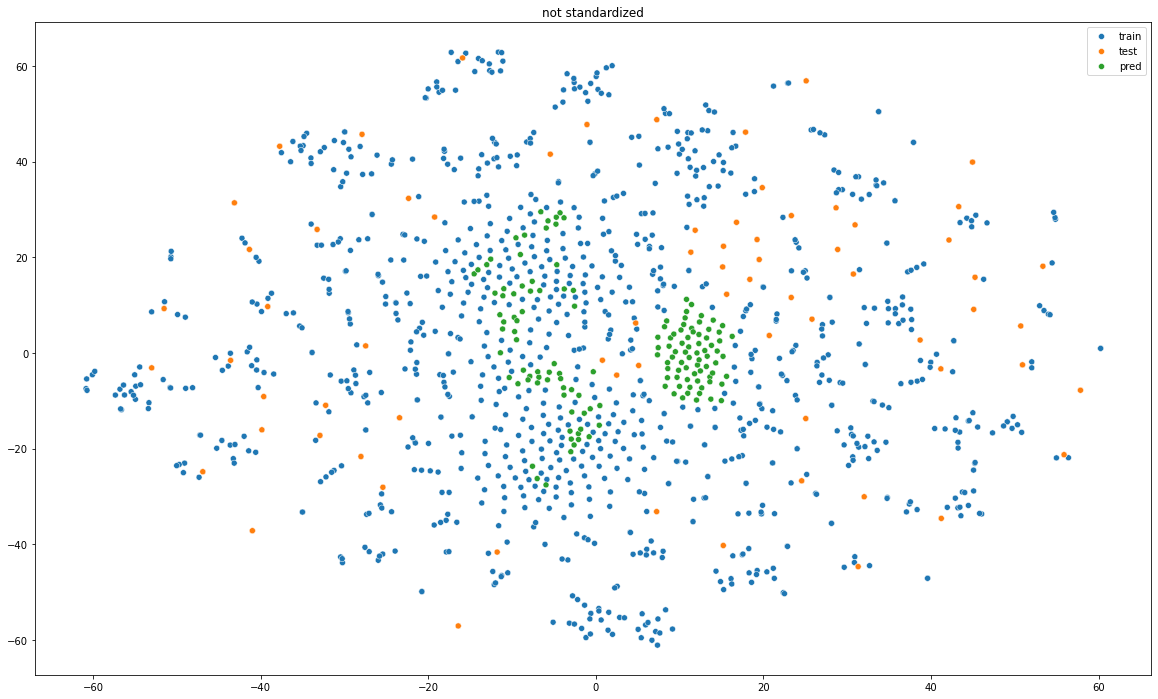

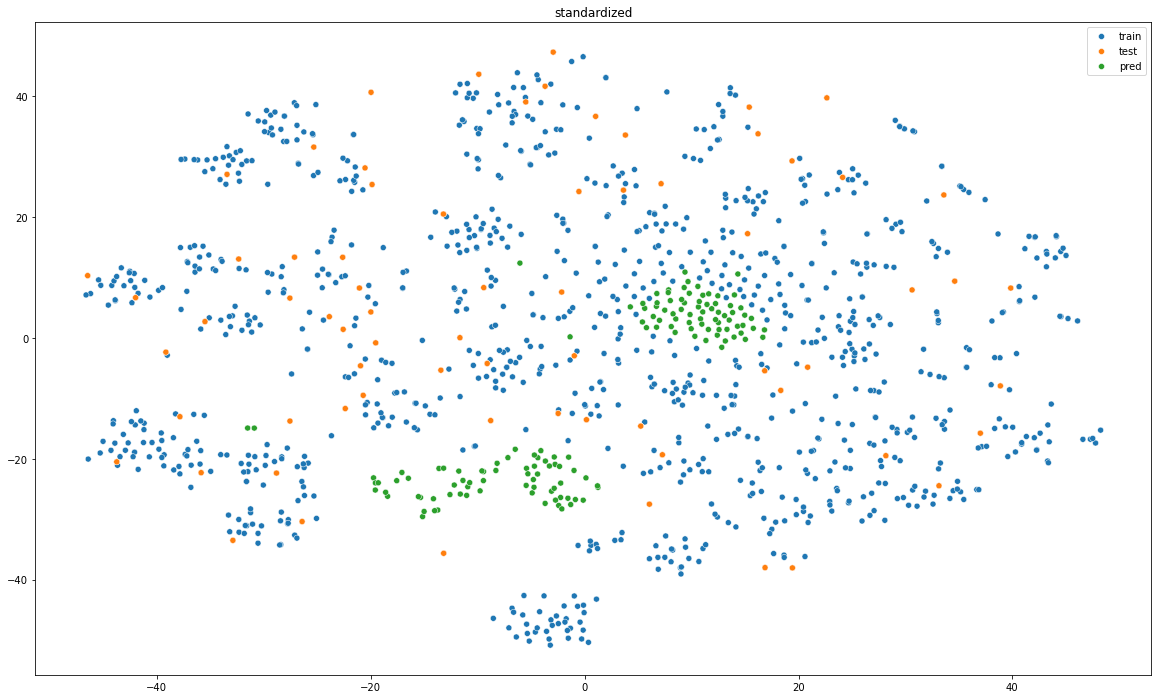

In [9]:
def plot_latents_tfce(train_lat, test_lat, pred_lat, title, train_subset=1000):
    train_latents_subset = train_latents[np.random.choice(range(len(train_lat)), size=train_subset, replace=False)]
    # train_test = np.concatenate((train_latents_subset, test_latents, preds))
    train_test = np.concatenate((train_latents_subset, test_lat, pred_lat))
    
    tsne = TSNE(n_components=2, learning_rate='auto', verbose=1, n_jobs=10, n_iter=1000)
    X_embedded = tsne.fit_transform(train_test)
    
    print(X_embedded.shape)
    assert X_embedded.shape[1] == 2
    hue = ['train'] * len(train_latents_subset) + ['test'] * len(test_lat) + ['pred'] * len(pred_lat)
    # alphas = [0.3] * len(train_latents_subset) + [1] * len(test_lat) + [1] * len(preds)
    
    plt.figure(figsize=(20, 12))
    sns.scatterplot(
        x = X_embedded[:, 0], y = X_embedded[:, 1],
        hue = hue,
        # alpha = alphas
    )
    plt.title(title)
    
plot_latents_tfce(train_latents, test_latents, pred_latents, title="not standardized")
plot_latents_tfce(train_latents, test_latents, pred_latents_standardized, "standardized")

# Nearest Neighbors with predictions averaged over subjects

In [10]:
N_NEIGHBORS = 5
NUM_SAMPLES = 5

def analysis_n_neighbors(test_preds, test_stim_ids, candidate_latents, candidate_latent_ids, stim_type):
    dist_mat = get_distance_matrix(test_preds, candidate_latents)

    print(f'pairwise acc: {dist_mat_to_pairwise_acc(dist_mat, test_stim_ids)}')
    print(f'mean rank: {dist_mat_to_rankings(dist_mat, test_stim_ids, candidate_latent_ids)}')

    np.random.seed(7)
    sampled_ids = np.random.choice(range(len(test_stim_ids)), NUM_SAMPLES, replace=False)
    test_stim_ids = test_stim_ids[sampled_ids]
    dist_mat = dist_mat[sampled_ids]

    nneighbors = [candidate_latent_ids[np.argsort(nneighbors_row)][:N_NEIGHBORS] for nneighbors_row in dist_mat]
                
    plot_nn_table(test_stim_ids, nneighbors, stim_type)

In [ ]:
WHOLE_TRAIN_SET_AS_CANDIDATE_SET = True

MODEL = "imagebind"

MODE = "train_image"
# MODE = "train_caption"
# MODE = "train"

BETAS_SUFFIX = 'betas'
# BETAS_SUFFIX = 'betas_backup'
# BETAS_SUFFIX = 'betas_one_step_backup'
BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

RESTANDARDIZE_PREDS = True if BETAS_SUFFIX == 'betas_backup' else False

FEATS = 'default'
TEST_FEATS = 'default'
VISION_FEATS = 'default'
LANG_FEATS = 'default'
FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)

all_preds = []
all_preds_standardized = []
for subj in SUBJECTS[:4]:
    stim_ids, stim_types, train_latents, test_latents, test_stim_ids, test_stim_types, gray_matter_mask, train_paths, test_paths, pred_latents, pred_latents_standardized = load(BETAS_DIR, MODEL, subj, MODE, FEATS_CONFIG)

    if RESTANDARDIZE_PREDS:
        all_preds.append(pred_latents_standardized)
    else:
        all_preds.append(pred_latents)

all_preds = np.mean(all_preds, axis=0)

for stim_type in [IMAGE]:#, CAPTION]:
    print(f'decoding of {stim_type}s')
    test_stim_ids_mod = test_stim_ids[test_stim_types == stim_type]
    test_latents_mod = test_latents[test_stim_types == stim_type]

    pred_latents_mod = all_preds[test_stim_types == stim_type]
        
    if WHOLE_TRAIN_SET_AS_CANDIDATE_SET:
        candidate_latents = np.concatenate((test_latents_mod, train_latents))
        candidate_latent_ids = np.concatenate((test_stim_ids_mod, stim_ids))
    else:
        candidate_latents = test_latents_mod
        candidate_latent_ids = test_stim_ids_mod

    analysis_n_neighbors(pred_latents_mod, test_stim_ids_mod, candidate_latents, candidate_latent_ids, stim_type)